In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
#import statsmodels.api as sm
from statsmodels.stats import multitest
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from cycler import cycler
import os
if os.getlogin() == 'jonesa7':
    import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def read_data(datapath, codebookpath):
    data = pd.read_csv(datapath, index_col='idno')
    metabolites = data.columns[4:]
    metabolites2exclude = [m for m in metabolites if data.loc[:, m].isna().sum() > len(data) * 0.2]
    data = data.drop(metabolites2exclude, axis=1)
    codebook = pd.read_csv(codebookpath, index_col='metabolite')
    data = data.rename(columns=dict(zip(codebook.index, codebook.MetaboliteName)))
    #data = data.rename(columns=dict(zip(codebook.index, tuple(zip(codebook.AnalyteClass, codebook.MetaboliteName)))))
    return(data)

if os.getlogin() == 'jonesa7':
    datapath_blood = '../../resources/rat-metabolites/Rat_blood_27_Oct_2022.csv'
    datapath_brain = '../../resources/rat-metabolites/Rat_brain_27_Oct_2022.csv'
    codebookpath = '../../resources/rat-metabolites/Rat_codebook_27_Oct_2022.csv'
else:
    datapath_blood = 'some/path'
    datapath_brain = 'some/path'
    codebookpath = 'some/path'

blood = read_data(datapath_blood, codebookpath)
brain = read_data(datapath_brain, codebookpath)
brain

,LIScore,Group,material,species,Taurocholic acid,Carnitine,Acetylcarnitine,Propionylcarnitine,Butyrylcarnitine,Valerylcarnitine,...,Phosphatidylethanolamine ae 40:1,Phosphatidylethanolamine ae 42:2,Phosphatidylglycerol aa 32:0,Phosphatidylglycerol aa 34:1,Phosphatidylglycerol aa 36:2,Phosphatidylglycerol aa 36:4,Phosphatidylglycerol aa 38:5,Phosphatidylserine aa 34:1,Phosphatidylserine aa 36:1,Phosphatidylserine aa 40:6
idno,,,,,,,,,,,,,,,,,,,,,
105,249,AI,brain tissue,rat,NaN,11.034,1.521,NaN,NaN,0.033825,...,1.097,1.350,0.3983,4.147,0.6962,2.943,0.6260,3.963,23.820,95.495
1158,201,AU,brain tissue,rat,0.32700,10.904,4.107,0.142000,0.158000,0.068129,...,1.234,1.143,0.3517,3.036,0.5238,2.593,0.5484,4.052,NaN,76.815
1172,155,AU,brain tissue,rat,0.37800,10.132,4.187,0.072465,0.128000,0.066152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1174,194,AU,brain tissue,rat,0.14600,10.024,4.249,0.146000,0.206000,0.132000,...,1.189,1.153,0.3748,3.530,0.5092,2.393,0.5173,3.979,34.066,65.968
127,291,AI,brain tissue,rat,NaN,11.611,3.001,NaN,0.088304,0.062654,...,1.145,1.413,0.4821,4.428,0.6463,2.665,0.5714,4.618,39.461,93.804
1368,285,AI,brain tissue,rat,0.03720,8.753,3.696,0.105000,0.145000,0.051299,...,1.234,1.368,0.3546,3.127,0.5751,2.273,0.5582,4.621,25.287,77.199
1416,274,AI,brain tissue,rat,0.62000,9.513,3.632,0.103000,0.145000,0.071780,...,1.313,1.448,0.4991,4.396,0.5918,2.794,0.6199,4.747,29.181,86.504
1424,216,AU,brain tissue,rat,0.60400,32.689,10.832,2.675000,0.447000,0.488000,...,1.184,1.161,0.3523,4.077,0.5641,2.460,0.5011,4.536,NaN,81.504
143,280,AI,brain tissue,rat,NaN,18.695,3.930,0.031219,0.105000,0.070783,...,1.547,1.343,0.4119,3.952,0.6400,2.335,0.5619,4.110,37.249,72.777


In [3]:
def extract2groups(metabolite, groupA='AU', groupB='AI', df=blood):
    l = [df.loc[df.Group == g, metabolite].dropna() for g in [groupA, groupB]]
    return(l)

def get_log_p(A, B):
    val = - np.log10(stats.ttest_ind(A, B)[1])
    return(val)

def get_effect_size(A, B):
    '''
    The effect size x is B relative to A, so if A > B => x < 0
    '''
    #val = B.mean() - A.mean() # the original definition; does not normalize effect size!
    OR = B.mean() / A.mean()
    log2OR = np.log2(OR)
    return(log2OR)

def get_both(metabolite, groupA='AU', groupB='AI', df=blood):
    A, B = extract2groups(metabolite, groupA, groupB, df)
    log_p = get_log_p(A, B)
    fx_size = get_effect_size(A, B)
    return((fx_size, log_p))

def get_both_all(groupA='AU', groupB='AI', df=blood):
     metabolites = df.columns[4:]
     l = [get_both(m, groupA, groupB, df) for m in metabolites]
     fx_sizes = [x[0] for x in l]
     log_ps = [x[1] for x in l]
     return((fx_sizes, log_ps))

In [4]:
comparisons = {
    'AI vs. AU': ['AU', 'AI'],
    'AI vs. Y': ['Y', 'AI'],
    'AU vs. Y': ['Y', 'AU'],
              }
results_blood = {k: get_both_all(*v, df=blood) for k, v in comparisons.items()}
results_brain = {k: get_both_all(*v, df=brain) for k, v in comparisons.items()}

In [5]:
def writeResults(dataset='brain', comparison = 'AI vs. AU', alpha=0.05, method='fdr_bh'):
    data = blood if dataset=='blood' else brain
    codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
    metabolites = data.columns[4:]
    metab_class = codebook.loc[metabolites, 'AnalyteClass']
    results = results_blood if dataset=='blood' else results_brain
    t = results[comparison]
    direction = ['Increase' if x>0 else 'Decrease' for x in t[0]]
    pvals = 10 ** (-np.array(t[1]))
    reject, pvals_corrected, alphacSidak, alphacBonf = multitest.multipletests(pvals, alpha=alpha, method=method)
    df = pd.DataFrame({'Dataset':dataset, 'Comparison': comparison,
                       'Analyte class': metab_class, 'Metabolite': metabolites,
                       'Effect size':t[0],'"- log p"':t[1], 'p': pvals,
                       r'Corrected p': pvals_corrected,
                       r'Reject H0': reject,
                       r'Bonferroni alpha': alphacBonf,
                       'Direction of change': direction})
    df = df.sort_values('Effect size')
    df = df.sort_values('p')
    df['Rank'] = np.arange(len(df)) + 1
    return(df)

In [6]:
l_blood = [writeResults(dataset='blood', comparison = c) for c in comparisons.keys()]
l_brain = [writeResults(dataset='brain', comparison = c) for c in comparisons.keys()]
summary = pd.concat(l_blood + l_brain)
summary

,Dataset,Comparison,Analyte class,Metabolite,Effect size,"""- log p""",p,Corrected p,Reject H0,Bonferroni alpha,Direction of change,Rank
Phosphatidylcholine aa C40:5,blood,AI vs. AU,Phosphatidylcholines,Phosphatidylcholine aa C40:5,-0.656900,1.831301,0.014747,0.758869,False,0.000189,Decrease,1
Linolenic acid,blood,AI vs. AU,Free_Fatty_Acids,Linolenic acid,-0.442021,1.707973,0.019590,0.758869,False,0.000189,Decrease,2
"5-beta,6-beta-Epoxycholesterol",blood,AI vs. AU,Free_Oxysterols,"5-beta,6-beta-Epoxycholesterol",-1.162864,1.677275,0.021024,0.758869,False,0.000189,Decrease,3
Spermine,blood,AI vs. AU,Amino_Acids_and_Biogenic_Amines,Spermine,0.550324,1.646695,0.022558,0.758869,False,0.000189,Increase,4
trans-4-Hydroxyproline,blood,AI vs. AU,Amino_Acids_and_Biogenic_Amines,trans-4-Hydroxyproline,0.969954,1.588279,0.025806,0.758869,False,0.000189,Increase,5
...,...,...,...,...,...,...,...,...,...,...,...,...
Phosphatidylethanolamine aa 38:5,brain,AU vs. Y,Phosphatidylethanolamines,Phosphatidylethanolamine aa 38:5,-0.002639,0.019312,0.956506,0.964968,False,0.000244,Decrease,201
Isoleucine,brain,AU vs. Y,Amino_Acids_and_Biogenic_Amines,Isoleucine,0.007180,0.018602,0.958071,0.964968,False,0.000244,Increase,202
Phosphatidylcholine aa C38:0,brain,AU vs. Y,Phosphatidylcholines,Phosphatidylcholine aa C38:0,-0.005627,0.017021,0.961567,0.964968,False,0.000244,Decrease,203
Phosphatidylcholine ae C30:1,brain,AU vs. Y,Phosphatidylcholines,Phosphatidylcholine ae C30:1,-0.018810,0.016472,0.962782,0.964968,False,0.000244,Decrease,204


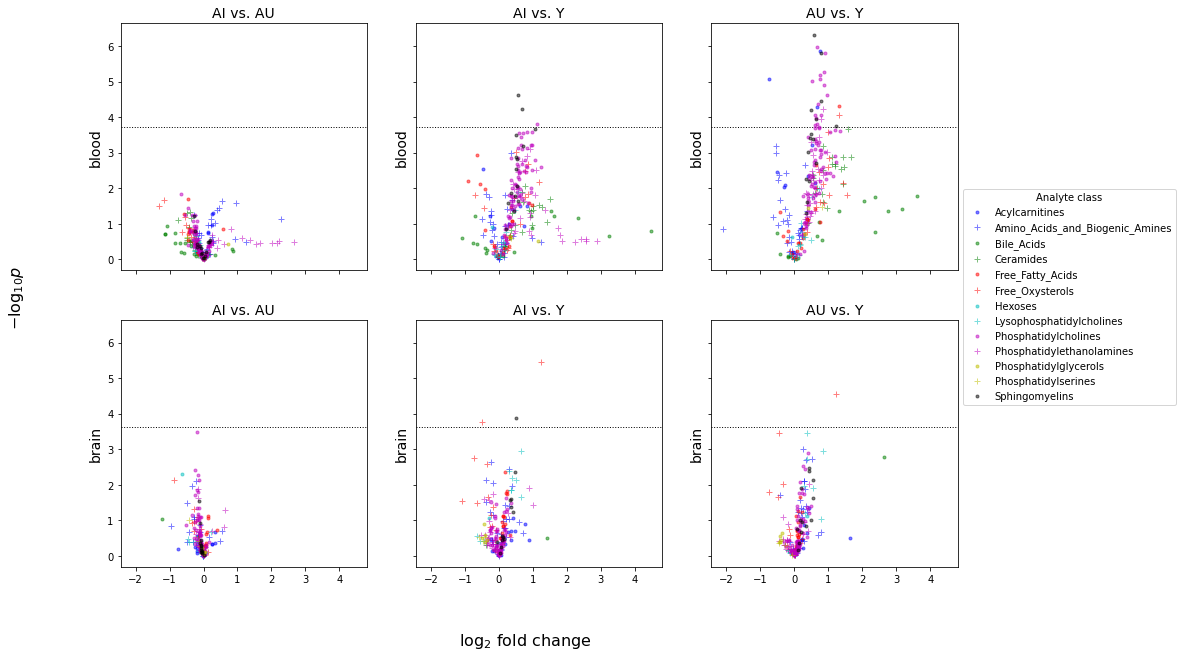

In [7]:
def volcano_subplot(axi, df, comparison, dataset, classes, dolabel=False):
    my_cycler = (cycler(color=list('bgrcmyk')) * cycler(marker=['.', '+']))
    axi.set_prop_cycle(my_cycler)
    for k, cls in enumerate(classes):
        clsdf = df.loc[df['Analyte class'] == cls]
        bonf_alpha = -np.log10(clsdf['Bonferroni alpha'].to_list()[0])
        if k == 0:
            axi.axhline(y=bonf_alpha, linestyle='dotted', color='black', linewidth=1)
        label = cls if dolabel else None
        axi.plot(clsdf['Effect size'], clsdf['"- log p"'], label=label, alpha=0.5, linestyle = '')
        #axi.scatter(x=clsdf['Effect size'], y=clsdf['"- log p"'], label=cls, alpha=0.5) # this does not work with cycler & marker 
        axi.set_title(comparison, fontsize=14)
        axi.set_ylabel(dataset, fontsize=14)
    return(axi)

def my_volcano(summary, swapij=False, figsize=(15, 10)):
    comparisons = np.unique(summary.Comparison)
    datasets = np.unique(summary.Dataset)
    classes = np.unique(summary['Analyte class'])
    fig, ax = plt.subplots(len(datasets), len(comparisons), figsize=figsize, sharey=True, sharex=True)
    for i, dataset in enumerate(datasets):
        for j, comparison in enumerate(comparisons):
            df = summary.loc[(summary.Dataset == dataset) & (summary.Comparison == comparison)]
            axi = ax[j, i] if swapij else ax[i, j]
            dolabel = (i == 0) and (j == 0)
            volcano_subplot(axi, df, comparison, dataset, classes, dolabel=dolabel)
    fig.supxlabel(r'$\log_{2}$ fold change', fontsize=16)
    fig.supylabel(r'$- \log_{10} p$', fontsize=16)
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), title='Analyte class')
    return((fig, ax))

fig, ax = my_volcano(summary)
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'volcano-plots')

In [8]:
%connect_info

{
  "shell_port": 58179,
  "iopub_port": 58180,
  "stdin_port": 58181,
  "control_port": 58183,
  "hb_port": 58182,
  "ip": "127.0.0.1",
  "key": "54dcd64b-fb00da5dd08c16fb6097e32c",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-1c495c84-eba8-469f-b606-a6faeca61d89.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
